<a href="https://colab.research.google.com/github/samantha-isaac/Emotion-Detection-in-Images-and-Music-Pairing-Through-AI/blob/main/CNN_SVM_Baseline_Landscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNs with SVMs Baseline for Landscape Dataset

Samantha Isaac

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, Input, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC  # Importar SVM
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

In [ ]:
# This is to mount Drive to this project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Connect to My Drive
%cd /content/drive/My Drive/

/content/drive/My Drive


In [ ]:
# Path to the folder for the Landscape dataset
dataset_folder = '/content/drive/MyDrive/Dissertation/Code/Data_Landscapes'

In [ ]:
# This function helps load the images and assigns as the labels the name of the correspodning folder
# References used for the function with os: https://docs.python.org/3/library/os.html
def load_images_and_labels(folder_path):
    images = []
    labels = []
    sub_folders = os.listdir(folder_path)

    for sub_folder in sub_folders:
        label = sub_folder # In here is where the name of the sub folders is taken as the label
        image_files = os.listdir(os.path.join(folder_path, sub_folder))

        for image_file in image_files:
            image_path = os.path.join(folder_path, sub_folder, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR) # It reads the images in BGR
            if image is not None:
                image = cv2.resize(image, (128, 128))  # Redimention the images
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # This is to convert from BGR to RGB
                # Reference for this: https://docs.opencv.org/4.x/d4/da8/group__imgcodecs.html
                images.append(image)
                labels.append(label)

    return np.array(images), labels

In [ ]:
# To load images and labels
images, labels = load_images_and_labels(dataset_folder)

In [ ]:
# To create the training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

In [ ]:
# To crerate a dictionary that assigns a numeric value to each label
label_map = {label: idx for idx, label in enumerate(set(train_labels))}
# For both training and testing dataset, it replace the label with the correspodning numeric value stablich in the line above
train_labels_numeric = [label_map[label] for label in train_labels]
test_labels_numeric = [label_map[label] for label in test_labels]

In [ ]:
# Convert labels to one-hot encoding. Reference from: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
num_classes = len(label_map)
train_labels_encoded = to_categorical(train_labels_numeric, num_classes=num_classes)
test_labels_encoded = to_categorical(test_labels_numeric, num_classes=num_classes)

In [ ]:
# To normalize and to convert in arrays of NumPy. Reference from: https://numpy.org/doc/stable/reference/generated/numpy.array.html
train_images = train_images / 255.0
test_images = test_images / 255.0
# To verify that the asignation of the values was made correctly
print("Mapping of labels to numeric values:")
print(label_map)

Mapping of labels to numeric values:
{'joy': 0, 'melancholy': 1, 'liveliness': 2, 'sadness': 3}


In [ ]:
# This was an extra added to improve the generalisability of the model, generating new modified versions of the images
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

In [ ]:
# Stablish the structure of the CNN model. Used a reference for most of the structure of the models
# the project of: https://medium.com/@skillcate/emotion-detection-model-using-cnn-a-complete-guide-831db1421fael
input = Input(shape=(128, 128, 3))
conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

flatten = Flatten()(pool2)
dense_1 = Dense(64, activation='relu')(flatten)
cnn_output = Dense(num_classes, activation="softmax")(dense_1)

cnn_model = Model(inputs=input, outputs=cnn_output)
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
cnn_model.summary() # To show the structure of the model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,102,564 (8.02 MB)

 Trainable params: 2,102,564 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# To train the model, and I specdify the parameters to use. Reference: https://stackoverflow.com/questions/37973005/what-do-model-predict-and-model-fit-do
history = cnn_model.fit(
    train_images,
    train_labels_encoded,
    validation_data=(test_images, test_labels_encoded),
    epochs=10,
    batch_size=32
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 496ms/step - accuracy: 0.2731 - loss: 2.0842 - val_accuracy: 0.2815 - val_loss: 1.3790
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 501ms/step - accuracy: 0.3017 - loss: 1.3589 - val_accuracy: 0.3288 - val_loss: 1.3341
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.4003 - loss: 1.2869 - val_accuracy: 0.3761 - val_loss: 1.2917
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - accuracy: 0.4738 - loss: 1.1685 - val_accuracy: 0.4820 - val_loss: 1.2303
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 471ms/step - accuracy: 0.6018 - loss: 0.9888 - val_accuracy: 0.4369 - val_loss: 1.2428
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 467ms/step - accuracy: 0.6851 - loss: 0.8672 - val_accuracy: 0.5113 - val_loss: 1.2865
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 468ms/step - accuracy: 0.7135 - loss: 0.7462 - val_accuracy: 0.4595 - val_loss: 1.2657
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - accuracy: 0.7690 - loss: 0.6525 - val_accu

In [ ]:
# This utilizes the previous CNN model.
feature_extractor = Model(inputs=cnn_model.input, outputs=flatten)
# This is to extract the characteristic of the images. Reference: https://scikit-learn.org/stable/modules/feature_extraction.html
train_features = feature_extractor.predict(train_images)
test_features = feature_extractor.predict(test_images)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step


In [ ]:
# I make instance of StandarScaler to normalise the data. Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
# This adjust the scaler. Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

In [ ]:
# This line of code creates the SVM model
svm_model = SVC(kernel = 'linear', C = 1)
# This is to train the SVM model
svm_model.fit(train_features, train_labels_numeric)

SVC(C=1, kernel='linear')

In [ ]:
# This line makes the actual predictions for the SVM with the CNN feature extractor
svm_predictions = svm_model.predict(test_features) # Reference: https://scikit-learn.org/stable/modules/svm.html

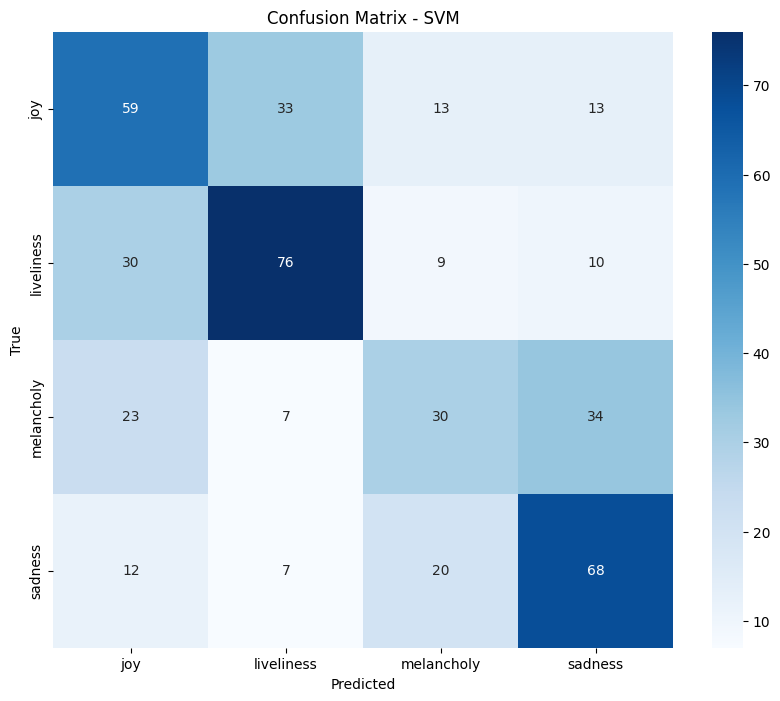

Classification report for SVM:
              precision    recall  f1-score   support

         joy       0.48      0.50      0.49       118
  liveliness       0.62      0.61      0.61       125
  melancholy       0.42      0.32      0.36        94
     sadness       0.54      0.64      0.59       107

    accuracy                           0.52       444
   macro avg       0.51      0.52      0.51       444
weighted avg       0.52      0.52      0.52       444



In [ ]:
# Convert the numeric labels back to text labels
index_to_label = {v: k for k, v in label_map.items()}
svm_pred_labels = [index_to_label[i] for i in svm_predictions]
svm_true_labels = [index_to_label[i] for i in test_labels_numeric]

# Define a consistent order for the labels, which is in alphabetical order
label_order = sorted(list(label_map.keys()))
# This is for the confusion matrix. Reference: https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/
cm_svm = confusion_matrix(svm_true_labels, svm_pred_labels, labels=label_order)

plt.figure(figsize = (10, 8))
sns.heatmap(cm_svm, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = label_order, yticklabels = label_order)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show()

# Show classification report
print("Classification report for SVM:")
print(classification_report(svm_true_labels, svm_pred_labels, target_names=label_order))

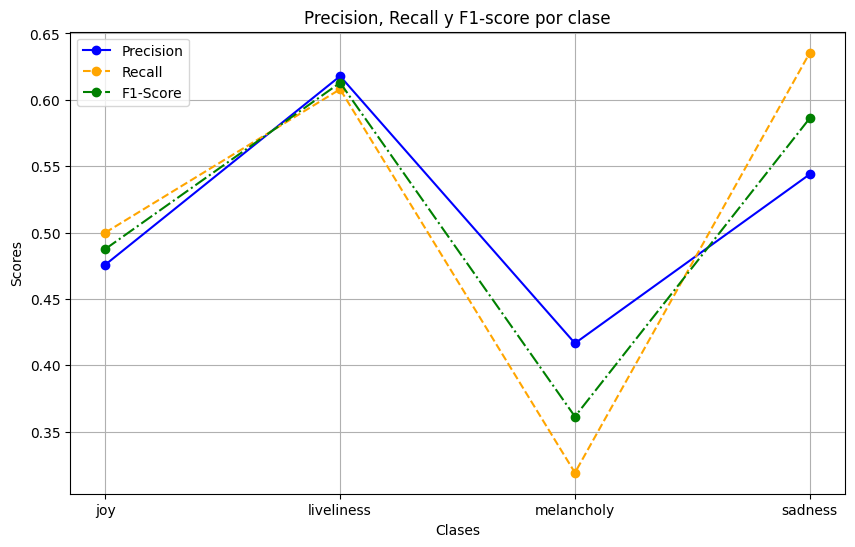

In [ ]:
# This is to calculate the corresponding metrics to determine the performance of the model
# Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
precision, recall, f1_score, _ = precision_recall_fscore_support(svm_true_labels, svm_pred_labels, labels = label_order)
plt.figure(figsize = (10, 6))
plt.plot(label_order, precision, marker = 'o', label = 'Precision', linestyle = '-', color = 'blue')
plt.plot(label_order, recall, marker = 'o', label = 'Recall', linestyle = '--', color = 'orange')
plt.plot(label_order, f1_score, marker = 'o', label = 'F1-Score', linestyle = '-.', color = 'green')

plt.title('Precision, Recall y F1-score por clase')
plt.xlabel('Clases')
plt.ylabel('Scores')
plt.legend(loc = 'best')
plt.grid(True)

plt.show();